# Question / Hypothesis

One assumption that is thrown around by managers/supervisors is that the handle time is not consistent throughout the day because phone representatives experience fatigue the more calls they take. Is there a difference in handle time the more calls a phone representative takes in a day?

### Change working directory to the location of the csv files

In [1]:
import os
os.getcwd()
os.chdir('D:\\Documents\\repos\\ThinkStats2\\code') 

# Importing packages

In [2]:
import numpy as np
import pandas as pd
# used for some plotting
import matplotlib.pyplot as plt
# used for manipulating time variables
from datetime import datetime
import scipy
# used for more advanced visualizations
import seaborn as sns
# used for analytical plots
import statsmodels.graphics.gofplots as sm
# recheck to see if this was used
# import scipy.stats as sc
# return pearson's correlation
from scipy.stats import pearsonr
# For Linear Regression
from sklearn.linear_model import LinearRegression

# Importing Call Data

In [3]:
# treat Initiation_TSP and Initiation_Dte as dates
health_df = pd.read_csv ('Health_Insurance_Call_Data.csv', parse_dates=['Initiation_TSP', 'Initiation_Dte'])

# Cleaning Data

In [4]:
# change [NULL] to null values
health_df['Attributes_Customer_Intent_Des'] = health_df['Attributes_Customer_Intent_Des'].replace('[NULL]', np.NaN)

In [5]:
# create a column for whether or not the call was transferred
health_df['Transfer_Flg'] = np.where(health_df['Transfer_Completed_TSP']== '[NULL]', 0, 1)

In [6]:
# update Attributes_authenticated_Ind to use 0 or 1
health_df['Attributes_authenticated_Ind'] = np.where(health_df['Attributes_authenticated_Ind']== 'TRUE', 1, 0)

In [7]:
# pull hour from initation timestamp
health_df['day_hour'] = health_df['Initiation_TSP'].dt.hour

In [8]:
# create new column for work hour
health_df['work_hour'] = health_df.SECONDS_AFTER_FIRST_CALL / 3600
health_df['work_hour'] = health_df['work_hour'].astype('int')

In [9]:
# drop unused columns
health_df = health_df.drop(columns=['Transfer_Completed_TSP'])

# Describe Variables

In [10]:
# overview of dataset
health_df.head(10)

,Agent_Routing_Profile_Nme,Attributes_Customer_Intent_Des,Initiation_TSP,Initiation_Dte,Contact_Id,QueueGroup,Queue_Nme,time_To_Answer_Sec_Cnt,time_To_Handle_Sec_Cnt,Agent_After_Contact_Work_Duration_Num,...,Agent_Customer_Hold_Dur_Num,Attributes_authenticated_Ind,MASKED_AGENT_ID,MASKED_DEPT_ID,MASKED_MGR_ID,DAILY_CALL_NUMBER,SECONDS_AFTER_FIRST_CALL,Transfer_Flg,day_hour,work_hour
0,POSHealthAccountManagement,Account Management,2022-06-01 09:01:00,2022-06-01,5b3041bd-905d-4e5e-802b-4a30da70af75,POSHealth,POSHealthAccountManagement,4,152,1,...,0,1,1,6,45,1,0,0,9,0
1,POSHealthAccountManagement,Account Management,2022-06-01 09:06:00,2022-06-01,ea008594-dd4f-489f-89ca-256b9274e84b,POSHealth,POSHealthAccountManagement,4,94,20,...,0,1,1,6,45,2,343,0,9,0
2,POSHealthAccountManagement,Account Management,2022-06-01 09:12:00,2022-06-01,35e8aeb1-6310-4bbc-a3eb-0ce4ae648aa1,POSHealth,POSHealthAccountManagement,4,104,1,...,41,1,1,6,45,3,656,1,9,0
3,POSHealthAccountManagement,Payment,2022-06-01 09:17:00,2022-06-01,8db27633-6838-4203-a34e-43f692290dca,POSHealth,POSHealthPayment,4,206,1,...,3,0,1,6,45,4,967,0,9,0
4,POSHealthAccountManagement,Payment,2022-06-01 09:20:00,2022-06-01,9d1c0d3b-2ed6-47d6-b288-ded737994974,POSHealth,POSHealthPayment,5,357,0,...,7,0,1,6,45,5,1190,0,9,0
5,POSHealthAccountManagement,Payment,2022-06-01 09:28:00,2022-06-01,be3e5a3f-db1b-4f8e-9920-c9958865afcc,POSHealth,POSHealthPayment,4,273,2,...,154,1,1,6,45,6,1639,0,9,0
6,POSHealthAccountManagement,Account Management,2022-06-01 09:36:00,2022-06-01,7d3e9476-13b9-43ce-aecb-a457dc4f0b74,POSHealth,POSHealthAccountManagement,5,98,1,...,0,1,1,6,45,7,2095,0,9,0
7,POSHealthAccountManagement,Account Management,2022-06-01 09:38:00,2022-06-01,015d8ba6-5677-4eea-8dff-65c91b7c63a7,POSHealth,POSHealthAccountManagement,4,516,1,...,0,1,1,6,45,8,2239,0,9,0
8,POSHealthAccountManagement,Account Management,2022-06-01 09:51:00,2022-06-01,730ff5cd-1e22-48d7-91cb-3dcec84bd7d5,POSHealth,POSHealthAccountManagement,4,319,1,...,99,0,1,6,45,9,2996,1,9,0
9,POSHealthAccountManagement,Account Management,2022-06-01 09:58:00,2022-06-01,ad7d0dad-0c94-40bf-a55c-298d4c2a6e27,POSHealth,POSHealthAccountManagement,5,186,1,...,0,0,1,6,45,10,3459,0,9,0


## Time to handle seconds

The total number of seconds it took the phone representative to handle the call. 

In [11]:
health_df['time_To_Handle_Sec_Cnt'].describe()

count    137625.000000
mean        290.290783
std         267.397806
min           1.000000
25%         125.000000
50%         219.000000
75%         366.000000
max       10007.000000
Name: time_To_Handle_Sec_Cnt, dtype: float64

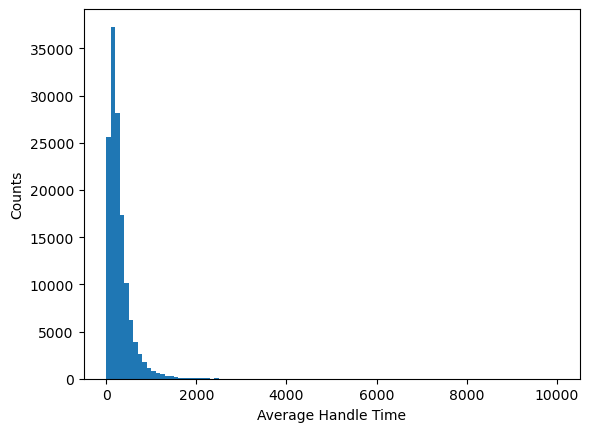

In [12]:
plt.hist(health_df['time_To_Handle_Sec_Cnt'], bins=100)
plt.xlabel('Average Handle Time')
plt.ylabel('Counts')
plt.show() 

### Time to handle seconds Outliers

- Extremely low handle times are usually an indicator of a dropped call
- Extremely high handle times could be instances where the call is extremely complex but could be a "stuck" call
- recommending removing any value that is greater than 3 times the 75th percentile


In [13]:
# 336 is the 75th percentile
# removing from dataset
health_df.drop(health_df[health_df['time_To_Handle_Sec_Cnt'] > 3*366].index, inplace = True)

## Daily Call Number

The call number within a day for a phone representative. 

In [14]:
health_df.DAILY_CALL_NUMBER.describe()

count    135068.000000
mean         32.181346
std          21.960871
min           1.000000
25%          14.000000
50%          29.000000
75%          47.000000
max         136.000000
Name: DAILY_CALL_NUMBER, dtype: float64

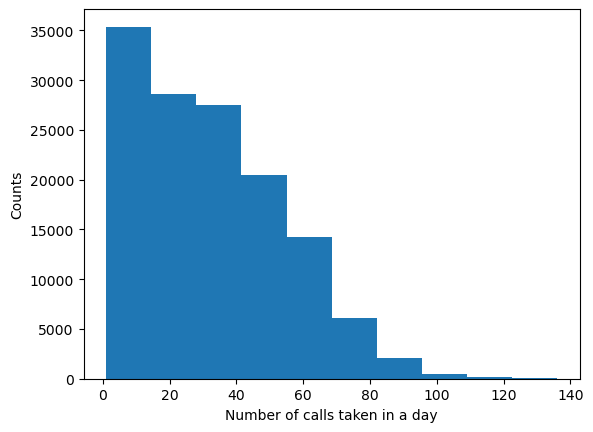

In [15]:
plt.hist(health_df['DAILY_CALL_NUMBER'])
plt.xlabel('Number of calls taken in a day')
plt.ylabel('Counts')
plt.show() 

### Daily Call Number Outliers

No outliers were identified

## Time to Answer Seconds

The time the customer waits in queue before it is answered by a phone representative.

In [16]:
health_df.time_To_Answer_Sec_Cnt.describe()

count    135068.000000
mean         38.270745
std          80.955940
min           1.000000
25%           4.000000
50%           6.000000
75%          30.000000
max        1062.000000
Name: time_To_Answer_Sec_Cnt, dtype: float64

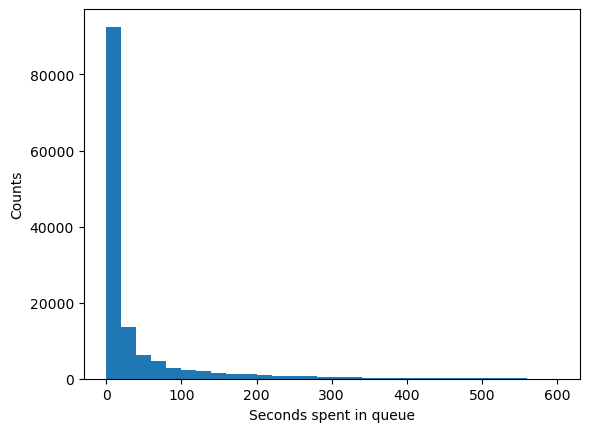

In [17]:
plt.hist(health_df['time_To_Answer_Sec_Cnt'], bins=30, range=[0, 600])
plt.xlabel('Seconds spent in queue')
plt.ylabel('Counts')
plt.show() 

### Time to answer seconds outliers

- Extremely high queue time could reflect where the caller was forced to wait more than usual or could reflect a call getting "stuck"
- I do not recommend removing any values from the dataset

# Seconds After First Call

The number of seconds after the first call was taken by a phone representative in a day. 

In [18]:
health_df.SECONDS_AFTER_FIRST_CALL.describe()

count    135068.000000
mean      13942.220333
std        9021.213939
min           0.000000
25%        6009.000000
50%       13098.000000
75%       21608.000000
max       37417.000000
Name: SECONDS_AFTER_FIRST_CALL, dtype: float64

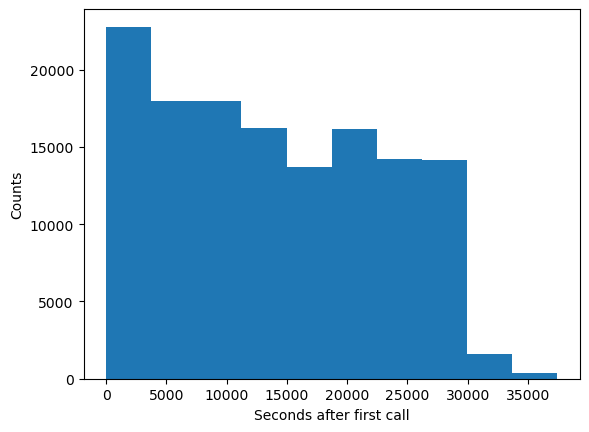

In [19]:
plt.hist(health_df['SECONDS_AFTER_FIRST_CALL'])
plt.xlabel('Seconds after first call')
plt.ylabel('Counts')
plt.show() 

## Seconds after first call outliers

Recommend removing any over 30000 since its such a small sample size

In [20]:
health_df.drop(health_df[health_df['SECONDS_AFTER_FIRST_CALL'] > 30000].index, inplace = True)

# Day Hour

The hour of the day in which the call arrived

In [21]:
health_df.day_hour.describe()

count    133293.000000
mean         11.729543
std           2.560111
min           6.000000
25%          10.000000
50%          12.000000
75%          14.000000
max          17.000000
Name: day_hour, dtype: float64

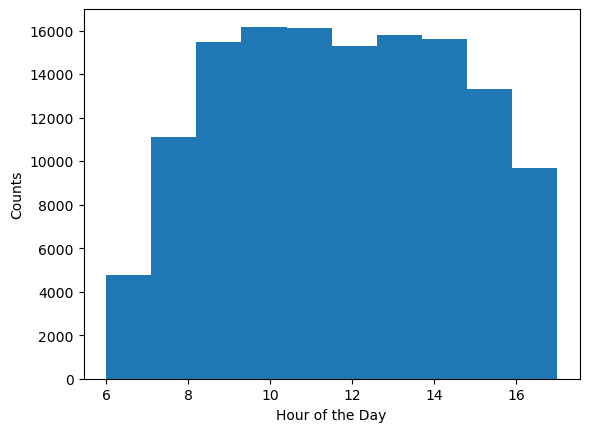

In [22]:
plt.hist(health_df['day_hour'])
plt.xlabel('Hour of the Day')
plt.ylabel('Counts')
plt.show() 

## Day Hour Outliers

No Outliers identified

# Probability Mass Function (PMF)

Mean of the number of calls taken within a day to determine what should be considered calls taken earlier in the shift versus later in the shift

In [23]:
health_df['DAILY_CALL_NUMBER'].mean()

31.666621653050047

In [24]:
# split dataset by the mean
early_calls = health_df[health_df['DAILY_CALL_NUMBER'] < 33]['time_To_Handle_Sec_Cnt']
late_calls = health_df[health_df['DAILY_CALL_NUMBER'] >= 33]['time_To_Handle_Sec_Cnt']

Calculate the PMF for both datasets

In [25]:
early_calls = early_calls.value_counts().sort_index() / len(early_calls)
late_calls = late_calls.value_counts().sort_index() / len(late_calls)

This plot compares the earlier calls that a phone representative takes vs the later calls that a phone representative takes

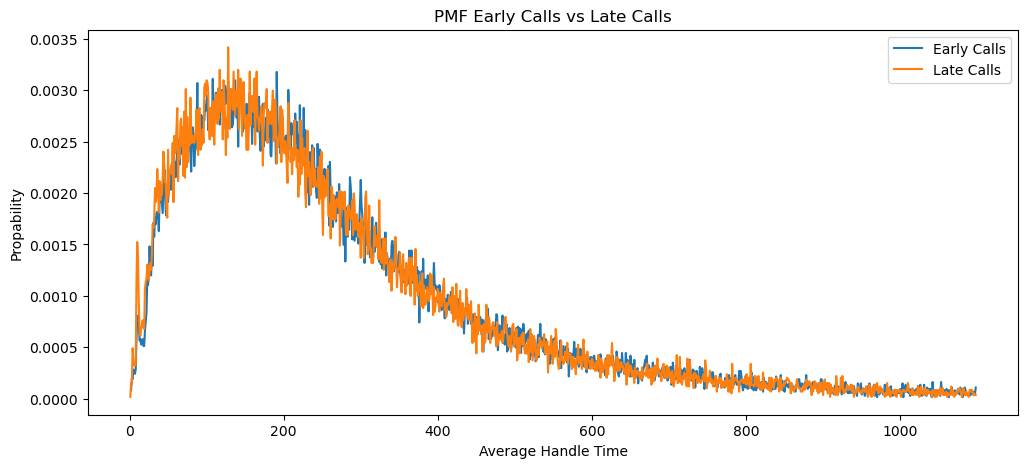

In [26]:
fig = plt.figure(figsize = (12, 5))
plt.plot(early_calls.index,early_calls.values, label = 'Early Calls')
plt.plot(late_calls.index,late_calls.values, label = 'Late Calls')
plt.xlabel('Average Handle Time')
plt.ylabel('Propability')
plt.title('PMF Early Calls vs Late Calls')
plt.legend()

# Cumulative Distribution Function (CDF)

In [27]:
# Calculate cdf using numpy's cumsum function and the pmf calculated previously
early_calls_cdf = early_calls.cumsum()
late_calls_cdf = late_calls.cumsum()

This plot compares the earlier calls that a phone representative takes vs the later calls that a phone representative takes

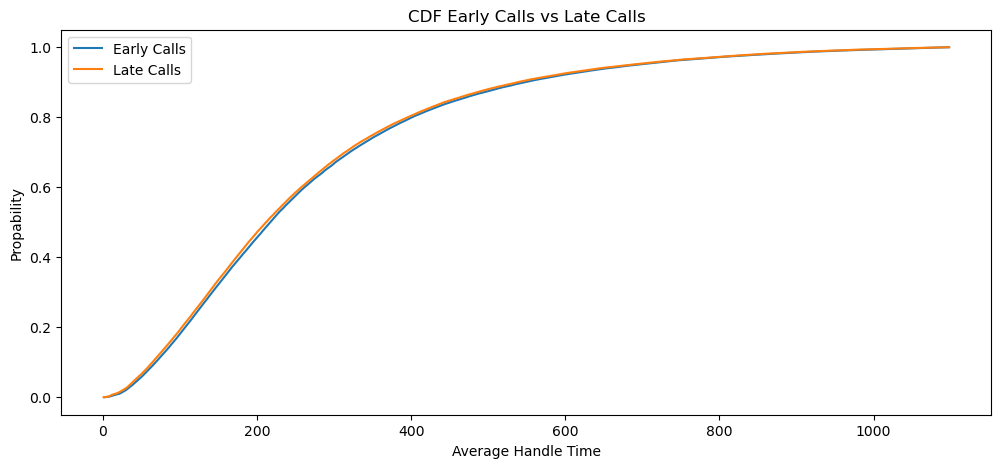

In [28]:
fig = plt.figure(figsize = (12, 5))
plt.plot(early_calls_cdf.index,early_calls_cdf.values, label = 'Early Calls')
plt.plot(late_calls_cdf.index,late_calls_cdf.values, label = 'Late Calls')
plt.xlabel('Average Handle Time')
plt.ylabel('Propability')
plt.title('CDF Early Calls vs Late Calls')
plt.legend()

# what does this tell you about your variable and how does it address the question you are trying to answer

There does not appear to be big flucuations between the earlier calls that they take and the later calls. This leads me to think that either there is no difference or I need to break down the comparisons in a different way. 

# Plot 1 analytical distribution and provide your analysis on how it applies to the dataset you have chosen.

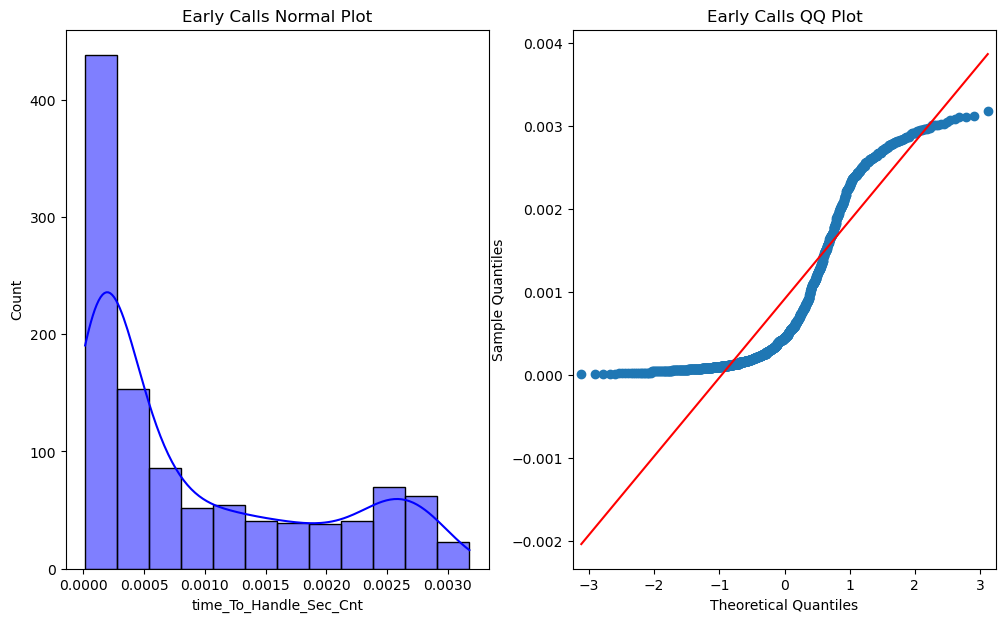

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
sns.histplot(early_calls,kde=True, color ='blue',ax=ax[0])
sm.ProbPlot(early_calls).qqplot(line='s', ax=ax[1])
ax[0].title.set_text('Early Calls Normal Plot')
ax[1].title.set_text('Early Calls QQ Plot');

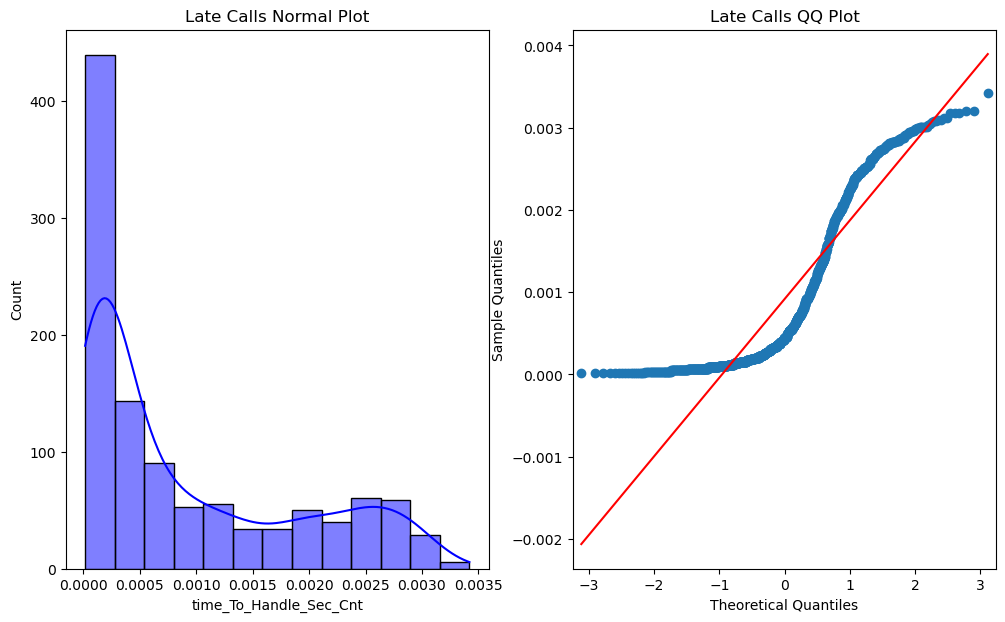

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
sns.histplot(late_calls,kde=True, color ='blue',ax=ax[0])
sm.ProbPlot(late_calls).qqplot(line='s', ax=ax[1])
ax[0].title.set_text('Late Calls Normal Plot')
ax[1].title.set_text('Late Calls QQ Plot');

## How it applies to the dataset you have chosen.

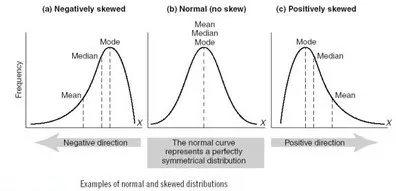

These plots tell us that the data is not normally distributed and is positively skewed which means the mean, median, and mode will all be different. It also means that there is a lower boundary to the data and no higher boundary. 



# Create two scatter plots comparing two variables.

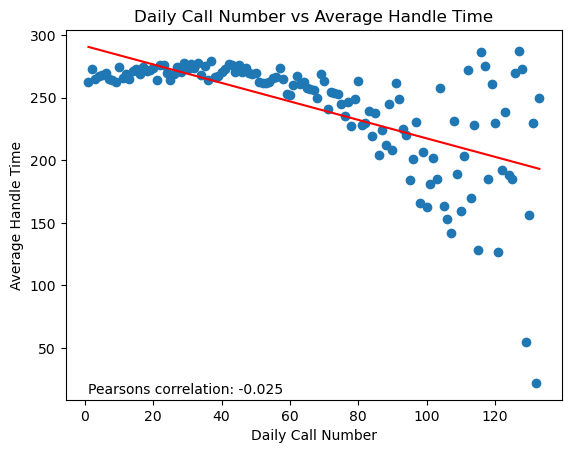

In [31]:
health_dcn_mean_df = health_df[['time_To_Handle_Sec_Cnt','DAILY_CALL_NUMBER']].groupby('DAILY_CALL_NUMBER').mean()
dcn_z = np.polyfit(health_dcn_mean_df.index, health_dcn_mean_df.time_To_Handle_Sec_Cnt, 1)
dcn_p = np.poly1d(dcn_z)
dcn_corr, _ = pearsonr(health_df['DAILY_CALL_NUMBER'], health_df['time_To_Handle_Sec_Cnt'])
plt.scatter(x = health_dcn_mean_df.index, y = health_dcn_mean_df.time_To_Handle_Sec_Cnt)
plt.plot(health_dcn_mean_df.index, dcn_p(health_dcn_mean_df.index), color="red")
plt.xlabel('Daily Call Number')
plt.ylabel('Average Handle Time')
plt.title('Daily Call Number vs Average Handle Time')
plt.text(1, 13,'Pearsons correlation: %.3f' % dcn_corr);

### Provide your analysis on correlation and causation. 

- The comparison between the daily call number and the average handle time shows a minimal negative correlation.
- I feel the trend line shown is skewed because of the small amount of data after 80 Daily Call Number has a lot of variation

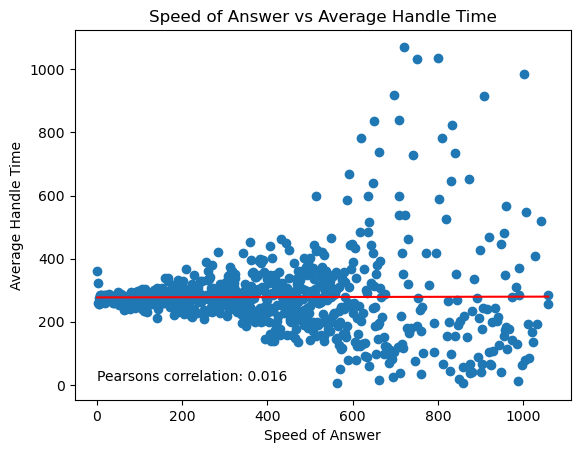

In [32]:
health_asa_mean_df = health_df[['time_To_Handle_Sec_Cnt','time_To_Answer_Sec_Cnt']].groupby('time_To_Answer_Sec_Cnt').mean()
asa_z = np.polyfit(health_asa_mean_df.index, health_asa_mean_df.time_To_Handle_Sec_Cnt, 1)
asa_p = np.poly1d(asa_z)
asa_corr, _ = pearsonr(health_df['time_To_Answer_Sec_Cnt'], health_df['time_To_Handle_Sec_Cnt'])
plt.scatter(x = health_asa_mean_df.index, y = health_asa_mean_df.time_To_Handle_Sec_Cnt)
plt.plot(health_asa_mean_df.index, asa_p(health_asa_mean_df.index), color="red")
plt.xlabel('Speed of Answer')
plt.ylabel('Average Handle Time')
plt.title('Speed of Answer vs Average Handle Time')
plt.text(1, 13,'Pearsons correlation: %.3f' % asa_corr);

### Provide your analysis on correlation and causation. 

- The comparison between the Speed of Answer and the average handle time shows a minimal positive correlation. 

# Conduct a test on your hypothesis

- NULL Hypothesis: There is no difference in handle time the more calls a phone representative takes
- Althernative Hypothesis: Calls taken later in the day have a higher handle time

In [33]:
from scipy.stats import ttest_ind

test_early_calls = health_df[health_df['DAILY_CALL_NUMBER'] < 33]['time_To_Handle_Sec_Cnt']
test_late_calls = health_df[health_df['DAILY_CALL_NUMBER'] >= 33]['time_To_Handle_Sec_Cnt']

t_stat, pvalue = ttest_ind(test_early_calls, test_late_calls)
print('t=statistics:', t_stat, '\np-value: ', pvalue)

t=statistics: 4.908965270728641 
p-value:  9.166611089891468e-07


Since the value is greater that 0.05, we can say that it is not statistically significant.

# For this project, conduct a regression analysis on either one dependent and one explanatory variable, or multiple explanatory variables (Chapter 10 & 11).

In [34]:
x=health_df[['time_To_Answer_Sec_Cnt','DAILY_CALL_NUMBER','day_hour']]
y=health_df['time_To_Handle_Sec_Cnt']

In [35]:
lm = LinearRegression()
lm.fit(x,y)
predictions = lm.predict(x)

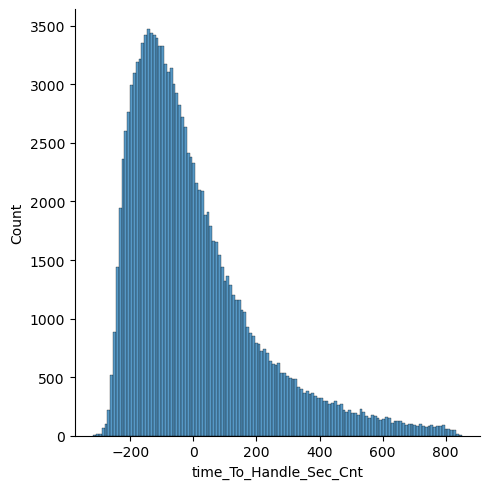

In [36]:
sns.displot((y-predictions));

In [37]:
coeff_df = pd.DataFrame(lm.coef_,x.columns,columns=['Coefficient'])
coeff_df

,Coefficient
time_To_Answer_Sec_Cnt,0.038653
DAILY_CALL_NUMBER,-0.866663
day_hour,6.894129


Interpreting the coefficients:
- Holding all other features fixed, a 1 second increase in **time_To_Answer_Sec_Cnt** is associated with an **increase of 0.038653 seconds of handle time**.
- Holding all other features fixed, a 1 call increase in **DAILY_CALL_NUMBER** is associated with an **decrease of 0.866663 seconds of handle time**.
- Holding all other features fixed, a 1 hour increase in **day_hour** is associated with an **increase of 6.894129 seconds of handle time**.

In [38]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y, predictions))
print('MSE:', metrics.mean_squared_error(y, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y, predictions)))

MAE: 151.99089354395682
MSE: 40000.05208708466
RMSE: 200.00013021766927
